In [147]:
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree

## Importing data
#training
file = "train.csv"
data_tr = pd.read_csv(file)
data_tr = data_tr.drop('surveyid', axis=1) #droping because it's not helpful in analysis
data_tr = data_tr.drop('survey_date', axis=1) #droping because it's not helpful in analysis

#test
file = "test.csv"
data_ts = pd.read_csv(file)
data_ts = data_ts.drop('surveyid', axis=1) #droping because it's not helpful in analysis
data_ts = data_ts.drop('survey_date', axis=1) #droping because it's not helpful in analysis

data_tr.head(n=5)


,village,femaleres,age,married,children,hhsize,edu,hh_children,hh_totalmembers,cons_nondurable,...,given_mpesa,amount_given_mpesa,received_mpesa,amount_received_mpesa,net_mpesa,saved_mpesa,amount_saved_mpesa,early_survey,depressed,day_of_week
0,91,1,28.0,1,4,6,10,0,NaN,0.00000,...,0,0.0,0,0.000000,0.000000,1,0.000000,0,0,5
1,57,1,23.0,1,3,5,8,0,NaN,0.00000,...,0,0.0,1,4.804611,4.804611,0,0.000000,0,1,3
2,115,1,22.0,1,3,5,9,0,NaN,0.00000,...,0,0.0,0,8.007685,8.007685,1,0.000000,0,0,5
3,97,1,27.0,1,2,4,10,2,4.0,378.83292,...,0,0.0,0,0.000000,0.000000,1,1.249199,0,0,0
4,42,0,59.0,0,4,6,10,4,6.0,258.67188,...,0,0.0,0,0.000000,0.000000,0,0.000000,0,0,3


In [148]:
# Looking at relevant numbers
n_records = data_tr.shape[0]
n_depressed = data_tr['depressed'].value_counts()[1]

print("Total number of records: {}".format(n_records))
print("Total number of people depressed: {}".format(n_depressed))
print("Percentage of people with depression: {:.2f}%".format(100*n_depressed/n_records))


Total number of records: 1143
Total number of people depressed: 193
Percentage of people with depression: 16.89%


In [149]:
## Making categorical variables into one-hot vector
cat_variables = ['village','femaleres','married','labor_primary','day_of_week']
one_hot_tr = pd.get_dummies(data_tr, columns = cat_variables)

data_ts['age'] = data_ts['age'].replace({'.d':np.nan})
one_hot_ts = pd.get_dummies(data_ts, columns = cat_variables)


## Taking out variables that have more than 500 missing values
listy = one_hot_tr.isnull().sum()
names = list(listy.index)
to_take_out = []
for element in names:
    if listy[element] >=500:
        to_take_out.append(element)
one_hot_tr = one_hot_tr.drop(to_take_out, axis=1)
one_hot_ts = one_hot_ts.drop(to_take_out, axis=1)

var_names_tr = list(one_hot_tr) #keeping track of variable names
var_names_ts = list(one_hot_ts) #keeping track of variable names

In [150]:
## Imputing missing values training data
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(one_hot_tr)
one_hot_tr= imp.transform(one_hot_tr)
train = pd.DataFrame(one_hot_tr)
train.columns = var_names_tr

## Imputing missing values test data
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(one_hot_ts)
one_hot_ts= imp.transform(one_hot_ts)
test = pd.DataFrame(one_hot_ts)
test.columns = var_names_ts

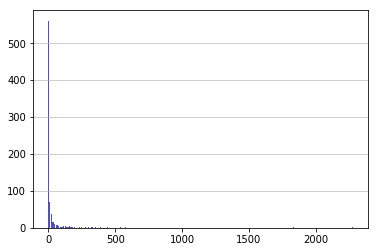

In [151]:
#### TEST CELL DELETE WITHOUT PROBLEM
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=train['nondurable_investment'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)

## to log scale: age, hhsize, children, hh_children, durable_investment, nondurable_investment

skewed = ['age', 'hhsize', 'children', 'hh_children', 'durable_investment', 'nondurable_investment']
train[skewed] = train[skewed].apply(lambda x: np.log(x + 1))
test[skewed] = test[skewed].apply(lambda x: np.log(x + 1))

In [152]:
## Scaling values training
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train = pd.DataFrame(train)
train.columns = var_names_tr

## Scaling values test
scaler = MinMaxScaler()
test = scaler.fit_transform(test)
test = pd.DataFrame(test)
test.columns = var_names_ts


In [153]:
# Splitting datasets into dependent variables and independent variables
X_train = train.drop('depressed', axis=1)
Y_train = train['depressed']

Y_test = test['depressed']
X_test = test.drop('depressed', axis=1)


### Making sure both datasets have the same variables
train_list = list(X_train)
test_list = list(X_test)
listy = []
for element in train_list:
    if element not in test_list:
        listy.append(element)
        X_test[element] = 0
       
for element in test_list:
    if element not in train_list:
        listy.append(element)
        X_train[element] = 0



In [154]:
## Fiting the relevant clasifier
clf = tree.DecisionTreeClassifier(min_samples_leaf=13)

clf.fit(X_train, Y_train)
Y_predicted = clf.predict(X_test)
print("Percentage of people predicted depression {:.2f}%".format(100*np.mean(Y_predicted)))

#Saving predictions
ids = pd.read_csv('test.csv')
ids = ids['surveyid']
ids = pd.DataFrame(ids)
Y_predicted = pd.DataFrame(Y_predicted)
Y_predicted.columns = ['depressed']

sub = pd.merge(ids,Y_predicted,left_index =True,right_index=True)

sub['depressed'] = sub['depressed'].astype(int)
sub.to_csv('andres_parrado_submissiontree.csv', encoding='utf-8')

Percentage of people predicted depression 10.49%


In [155]:
## Fiting the relevant clasifier
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='liblinear', C=.4)
clf.fit(X_train, Y_train)
Y_predicted = clf.predict(X_test)
print("Percentage of people predicted depression {:.2f}%".format(100*np.mean(Y_predicted)))

#Saving predictions
ids = pd.read_csv('test.csv')
ids = ids['surveyid']
ids = pd.DataFrame(ids)
Y_predicted = pd.DataFrame(Y_predicted)
Y_predicted.columns = ['depressed']

sub = pd.merge(ids,Y_predicted,left_index =True,right_index=True)

sub['depressed'] = sub['depressed'].astype(int)
sub.to_csv('logistic.csv', encoding='utf-8')

Percentage of people predicted depression 14.69%


In [156]:
from sklearn.svm import SVC  

clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)
Y_predicted = clf.predict(X_test)
print("Percentage of people predicted depression {:.2f}%".format(100*np.mean(Y_predicted)))

#Saving predictions
ids = pd.read_csv('test.csv')
ids = ids['surveyid']
ids = pd.DataFrame(ids)
Y_predicted = pd.DataFrame(Y_predicted)
Y_predicted.columns = ['depressed']

sub = pd.merge(ids,Y_predicted,left_index =True,right_index=True)

sub['depressed'] = sub['depressed'].astype(int)
sub.to_csv('andres_parrado_submissionsvm.csv', encoding='utf-8')

Percentage of people predicted depression 1.40%


In [157]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=2,weights = 'distance') 
clf.fit(X_train, Y_train)
Y_predicted = clf.predict(X_test)
print("Percentage of people predicted depression {:.2f}%".format(100*np.mean(Y_predicted)))

#Saving predictions
ids = pd.read_csv('test.csv')
ids = ids['surveyid']
ids = pd.DataFrame(ids)
Y_predicted = pd.DataFrame(Y_predicted)
Y_predicted.columns = ['depressed']

sub = pd.merge(ids,Y_predicted,left_index =True,right_index=True)

sub['depressed'] = sub['depressed'].astype(int)
sub.to_csv('andres_parrado_submissionknn.csv', encoding='utf-8')

Percentage of people predicted depression 9.79%


In [158]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=0)
clf.fit(X_train, Y_train)
Y_predicted = clf.predict(X_test)
print("Percentage of people predicted depression {:.2f}%".format(100*np.mean(Y_predicted)))

#Saving predictions
ids = pd.read_csv('test.csv')
ids = ids['surveyid']
ids = pd.DataFrame(ids)
Y_predicted = pd.DataFrame(Y_predicted)
Y_predicted.columns = ['depressed']

sub = pd.merge(ids,Y_predicted,left_index =True,right_index=True)

sub['depressed'] = sub['depressed'].astype(int)
sub.to_csv('andres_parrado_submissionforest.csv', encoding='utf-8')

Percentage of people predicted depression 0.00%


In [159]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

#Initializing Neural Network
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim = 3, init = 'uniform', activation = 'relu', input_dim = 330))

# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# Compiling Neural Network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fitting our model 
classifier.fit(X_train, Y_train, batch_size = 2, nb_epoch = 100)


# Predicting the Test set results
Y_pred = classifier.predict(X_test)
Y_predicted = (Y_pred > 0.5)


print("Percentage of people predicted depression {:.2f}%".format(100*np.mean(Y_predicted)))

#Saving predictions
ids = pd.read_csv('test.csv')
ids = ids['surveyid']
ids = pd.DataFrame(ids)
Y_predicted = pd.DataFrame(Y_predicted)
Y_predicted.columns = ['depressed']

sub = pd.merge(ids,Y_predicted,left_index =True,right_index=True)

sub['depressed'] = sub['depressed'].astype(int)
sub.to_csv('deep_net.csv', encoding='utf-8')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=330, units=3, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/100
1143/1143 [==============================] - 1s 1ms/step - loss: 0.5070 - acc: 0.8311
Epoch 2/100
1143/1143 [==============================] - 1s 626us/step - loss: 0.4533 - acc: 0.8311
Epoch 3/100
1143/1143 [==============================] - 1s 628us/step - loss: 0.4492 - acc: 0.8311
Epoch 4/100
1143/1143 [==============================] - 1s 630us/step - loss: 0.4439 - acc: 0.8311
Epoch 5/100
1143/1143 [==============================] - 1s 635us/step - loss: 0.4392 - acc: 0.8311
Epoch 6/100
1143/1143 [==============================] - 1s 632us/step - loss: 0.4335 - acc: 0.8311
Epoch 7/100
1143/1143 [==============================] - 1s 643us/step - loss: 0.4271 - acc: 0.8311
Epoch 8/100
1143/1143 [==============================] - 1s 631us/step - loss: 0.4208 - acc: 0.8311
Epoch 9/100
1143/1143 [==============================] - 1s 634us/step - loss: 0.4139 - acc: 0.8311
Epoch 10/100
1143/1143 [==============================] - 1s 620us/step - loss: 0.4038 - acc: 0.8311
E

1143/1143 [==============================] - 1s 600us/step - loss: 0.1973 - acc: 0.9204
Epoch 82/100
1143/1143 [==============================] - 1s 636us/step - loss: 0.1958 - acc: 0.9274
Epoch 83/100
1143/1143 [==============================] - 1s 636us/step - loss: 0.1930 - acc: 0.9256
Epoch 84/100
1143/1143 [==============================] - 1s 611us/step - loss: 0.1921 - acc: 0.9239
Epoch 85/100
1143/1143 [==============================] - 1s 614us/step - loss: 0.1886 - acc: 0.9256
Epoch 86/100
1143/1143 [==============================] - 1s 598us/step - loss: 0.1870 - acc: 0.9283
Epoch 87/100
1143/1143 [==============================] - 1s 624us/step - loss: 0.1832 - acc: 0.9326
Epoch 88/100
1143/1143 [==============================] - 1s 604us/step - loss: 0.1828 - acc: 0.9353
Epoch 89/100
1143/1143 [==============================] - 1s 654us/step - loss: 0.1791 - acc: 0.9318
Epoch 90/100
1143/1143 [==============================] - 1s 707us/step - loss: 0.1773 - acc: 0.9335
Epo